In [1]:
import keras
from keras.layers import Input, Dense, Flatten, Conv1D, LSTM, Dropout
from keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from train import parse_config, get_features

Option = namedtuple("MyStruct", "inputModel inputFile tree config outputDir ")
options = Option(
    inputModel = 'KERAS_conv1d_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_conv1d.yml',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Using TensorFlow backend.


Loading configuration from train_config_conv1d.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_costhetarel',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'conv1d_model',
 'KerasModelRetrain': 'conv1d_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 100}

In [2]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]
#features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_costhetarel','j1_pdgid','j1_pt']
#labels = ['j_g','j_q','j_w','j_z','j_t']

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df

,j1_deltaR,j1_costhetarel,j_g,j1_erel,j_q,j1_ptrel,j_z,j1_etarot,j_w,j_t,j_index,j1_pdgid,j1_phirot
0,0.011056,6.123234e-17,1,0.382772,0,0.386118,0,0.000000,0,0,101333,130.0,0.000000
1,0.023104,-9.858313e-03,1,0.105703,0,0.107734,0,-0.009859,0,0,101333,211.0,0.007236
2,0.006306,4.508108e-03,1,0.094339,0,0.094731,0,0.004508,0,0,101333,321.0,-0.002759
3,0.022473,2.855927e-02,1,0.042913,0,0.042086,0,0.028567,0,0,101333,211.0,-0.014909
4,0.025492,-1.801822e-02,1,0.038547,0,0.039412,0,-0.018020,0,0,101333,-211.0,-0.003745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131608,0.380018,-2.917658e-01,0,0.000344,0,0.000350,1,-0.300495,0,0,300123134,111.0,-0.315306
5131609,0.294476,2.532998e-01,0,0.000256,0,0.000258,1,0.258936,0,0,300123134,111.0,-0.349366
5131610,0.255231,2.628331e-01,0,0.000215,0,0.000219,1,0.269149,0,0,300123134,111.0,-0.270430
5131611,0.319973,-2.099133e-01,0,0.000115,0,0.000116,1,-0.213081,0,0,300123134,111.0,-0.341398


In [3]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)


C:\Users\jjren\CNN1D\train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

# Self-Build Model

In [10]:
l1Reg = 0.0001

Inputs = Input(shape = (100,7))

x = Conv1D(filters= 8, kernel_size=4, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(Inputs)
x = Conv1D(filters= 4, kernel_size=4, strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(x)
x = Conv1D(filters=2, kernel_size=4, strides=3, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(x)

x = Flatten()(x)

x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc1_relu', kernel_regularizer=l1(l1Reg))(x)

predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 7)]          0         
_________________________________________________________________
conv1_relu_1 (Conv1D)        (None, 100, 8)            232       
_________________________________________________________________
conv1_relu_2 (Conv1D)        (None, 50, 4)             132       
_________________________________________________________________
conv1_relu_3 (Conv1D)        (None, 17, 2)             34        
_________________________________________________________________
flatten_1 (Flatten)          (None, 34)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                1120      
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 165 

In [11]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)



Epoch 1/100
58/58 [==============================] - 1s 25ms/step - loss: 1.6177 - accuracy: 0.2198 - val_loss: 1.5610 - val_accuracy: 0.2641
Epoch 2/100
58/58 [==============================] - 1s 24ms/step - loss: 1.4251 - accuracy: 0.3754 - val_loss: 1.3070 - val_accuracy: 0.4520
Epoch 3/100
58/58 [==============================] - 1s 24ms/step - loss: 1.2372 - accuracy: 0.4942 - val_loss: 1.1662 - val_accuracy: 0.5339
Epoch 4/100
58/58 [==============================] - 1s 24ms/step - loss: 1.1188 - accuracy: 0.5531 - val_loss: 1.0710 - val_accuracy: 0.5710
Epoch 5/100
58/58 [==============================] - 1s 23ms/step - loss: 1.0453 - accuracy: 0.5869 - val_loss: 1.0171 - val_accuracy: 0.5989
Epoch 6/100
58/58 [==============================] - 1s 25ms/step - loss: 1.0010 - accuracy: 0.6054 - val_loss: 0.9821 - val_accuracy: 0.6083
Epoch 7/100
58/58 [==============================] - 1s 24ms/step - loss: 0.9749 - accuracy: 0.6182 - val_loss: 0.9626 - val_accuracy: 0.6230
Epoch 

58/58 [==============================] - 1s 22ms/step - loss: 0.7731 - accuracy: 0.7309 - val_loss: 0.7797 - val_accuracy: 0.7271
Epoch 59/100
58/58 [==============================] - 1s 22ms/step - loss: 0.7710 - accuracy: 0.7320 - val_loss: 0.7766 - val_accuracy: 0.7295
Epoch 60/100
58/58 [==============================] - 1s 22ms/step - loss: 0.7702 - accuracy: 0.7331 - val_loss: 0.7739 - val_accuracy: 0.7314
Epoch 61/100
58/58 [==============================] - 1s 22ms/step - loss: 0.7694 - accuracy: 0.7334 - val_loss: 0.7748 - val_accuracy: 0.7290
Epoch 62/100
58/58 [==============================] - 1s 22ms/step - loss: 0.7693 - accuracy: 0.7337 - val_loss: 0.7733 - val_accuracy: 0.7323
Epoch 63/100
58/58 [==============================] - 1s 22ms/step - loss: 0.7677 - accuracy: 0.7333 - val_loss: 0.7765 - val_accuracy: 0.7304
Epoch 64/100
58/58 [==============================] - 1s 22ms/step - loss: 0.7678 - accuracy: 0.7341 - val_loss: 0.7726 - val_accuracy: 0.7326
Epoch 65/100

# Conv1d Evaluation

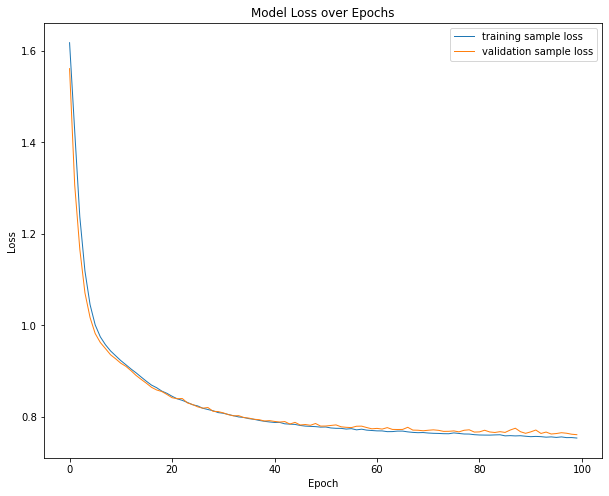

In [12]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)

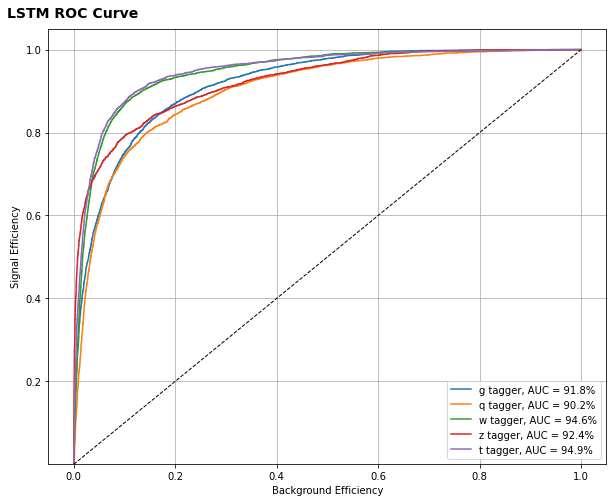

In [13]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv1d')

Text(0.25, 0.9, 'Conv_1d_notebook_version')

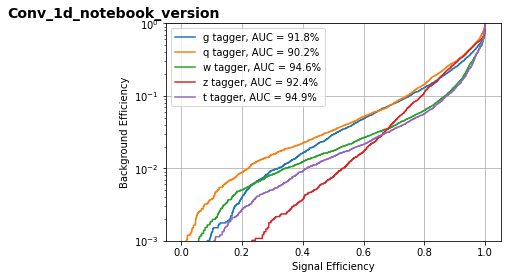

In [14]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_1d_notebook_version',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)